## Import Needed Libraries

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
import joblib
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## Read Data

In [2]:
data_dir='/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'
target_folder='Lymphoma'
filepath=[]
labels=[]
all_folder_path = os.path.join(data_dir, target_folder)

if os.path.isdir(all_folder_path):
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)
        fipath=os.listdir(fpath)
        for image in fipath:
            path = os.path.join(fpath, image)
            filepath.append(path)
            labels.append(f)  

f_series = pd.Series(filepath, name='filepath')
l_series = pd.Series(labels, name='labels')
df = pd.concat([f_series, l_series], axis=1)

In [3]:
df

filepath     labels
0      /kaggle/input/multi-cancer/Multi Cancer/Multi ...   lymph_fl
1      /kaggle/input/multi-cancer/Multi Cancer/Multi ...   lymph_fl
2      /kaggle/input/multi-cancer/Multi Cancer/Multi ...   lymph_fl
3      /kaggle/input/multi-cancer/Multi Cancer/Multi ...   lymph_fl
4      /kaggle/input/multi-cancer/Multi Cancer/Multi ...   lymph_fl
...                                                  ...        ...
14995  /kaggle/input/multi-cancer/Multi Cancer/Multi ...  lymph_mcl
14996  /kaggle/input/multi-cancer/Multi Cancer/Multi ...  lymph_mcl
14997  /kaggle/input/multi-cancer/Multi Cancer/Multi ...  lymph_mcl
14998  /kaggle/input/multi-cancer/Multi Cancer/Multi ...  lymph_mcl
14999  /kaggle/input/multi-cancer/Multi Cancer/Multi ...  lymph_mcl

[15000 rows x 2 columns]

## display amount of Labels

In [4]:
count_df=df['labels'].value_counts().reset_index()
count_df.columns=['labels','count']
fig_df=px.bar(count_df,x='labels',y='count',title='count of labels in df',text_auto=True)
fig_df.show()

## split data

In [5]:
strat=df['labels']
train_df,dummy_df=train_test_split(df,test_size=0.2,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [6]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(12000, 2)
(1500, 2)
(1500, 2)


## Visulization

In [7]:
count_train=train_df['labels'].value_counts().reset_index()
count_train.columns=['labels','count']
fig_train=px.bar(count_train,x='labels',y='count',title='count of labels in train_df',text_auto=True)
fig_train.show()

In [8]:
count_valid=valid_df['labels'].value_counts().reset_index()
count_valid.columns=['labels','count']
fig_valid=px.bar(count_valid,x='labels',y='count',title='count of labels in valid_df',text_auto=True)
fig_valid.show()

In [9]:
count_test=test_df['labels'].value_counts().reset_index()
count_test.columns=['labels','count']
fig_test=px.bar(count_test,x='labels',y='count',title='count of labels in test_df',text_auto=True)
fig_test.show()

## Data Augmentation

In [10]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


## sample of data

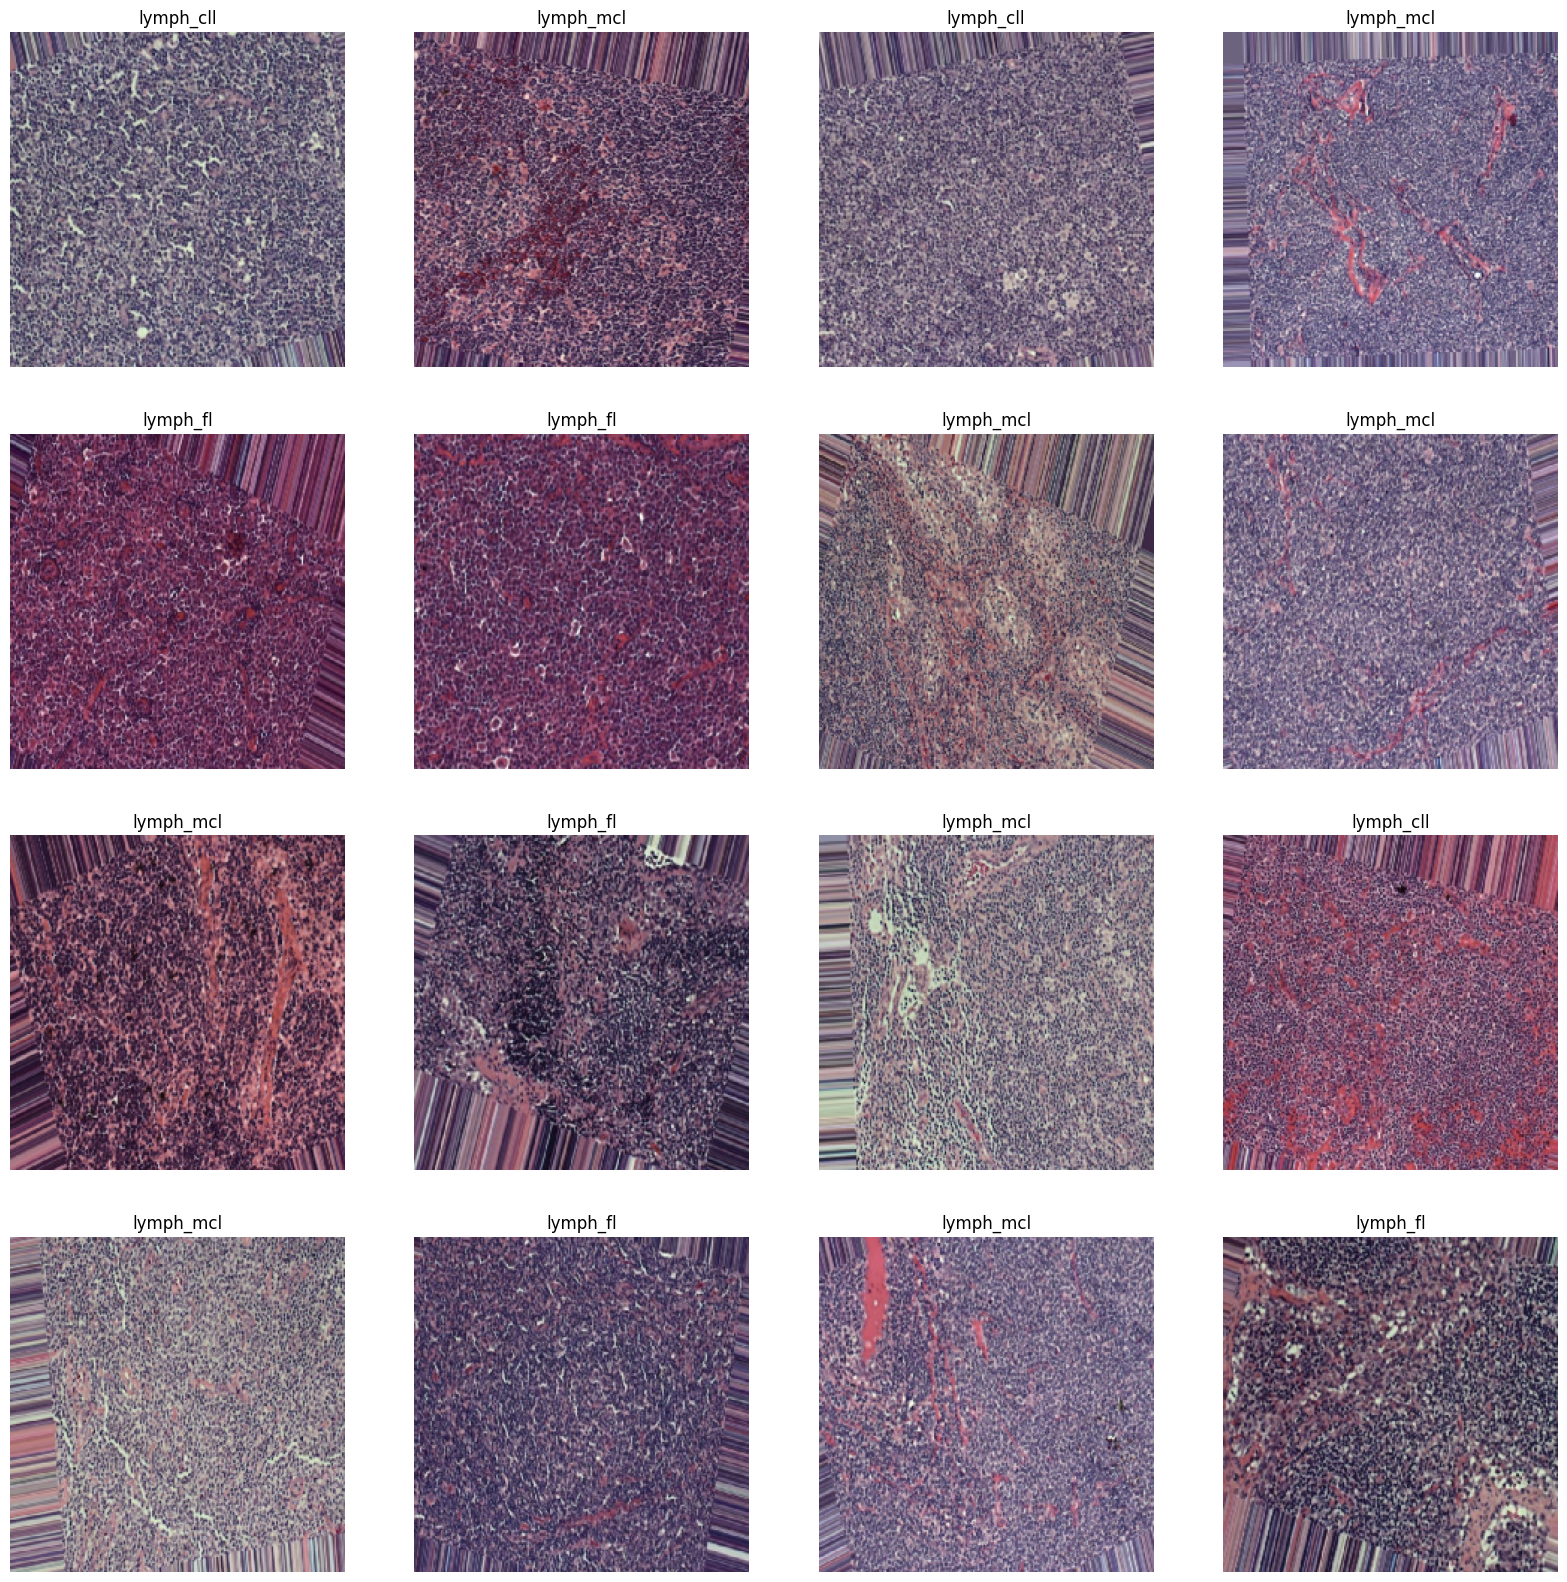

In [11]:
g_dict = train_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(train_gen)     

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

## Bulid Model

In [12]:
base_model=keras.applications.EfficientNetB0(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(64,activation='relu'),
    Dense(3,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.01), loss= 'categorical_crossentropy', metrics= ['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history=model.fit(train_gen,epochs=100,validation_data=valid_gen,shuffle=False,
                  callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1730301455.399025      68 service.cc:145] XLA service 0x792df4004550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730301455.399081      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730301502.478981      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.5358 - loss: 3.9506 - val_accuracy: 0.3480 - val_loss: 14.8423
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 58s 309ms/step - accuracy: 0.9362 - loss: 0.1917 - val_accuracy: 0.7513 - val_loss: 1.1385
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 59s 315ms/step - accuracy: 0.9826 - loss: 0.0526 - val_accuracy: 0.9960 - val_loss: 0.0138
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 299ms/step - accuracy: 0.9907 - loss: 0.0330 - val_accuracy: 0.9900 - val_loss: 0.0385
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 57s 305ms/step - accuracy: 0.9908 - loss: 0.0262 - val_accuracy: 0.9887 - val_loss: 0.0343
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 58s 305ms/step - accuracy: 0.9914 - loss: 0.0250 - val_accuracy: 0.9773 - val_loss: 0.0834
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 57s 300ms/step - accuracy: 0.9967 - loss: 0.0136 - val_accuracy: 0.9993 - val_loss: 9.1323e-04
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 59s 315ms/step - accuracy: 0.9929 - loss: 0.

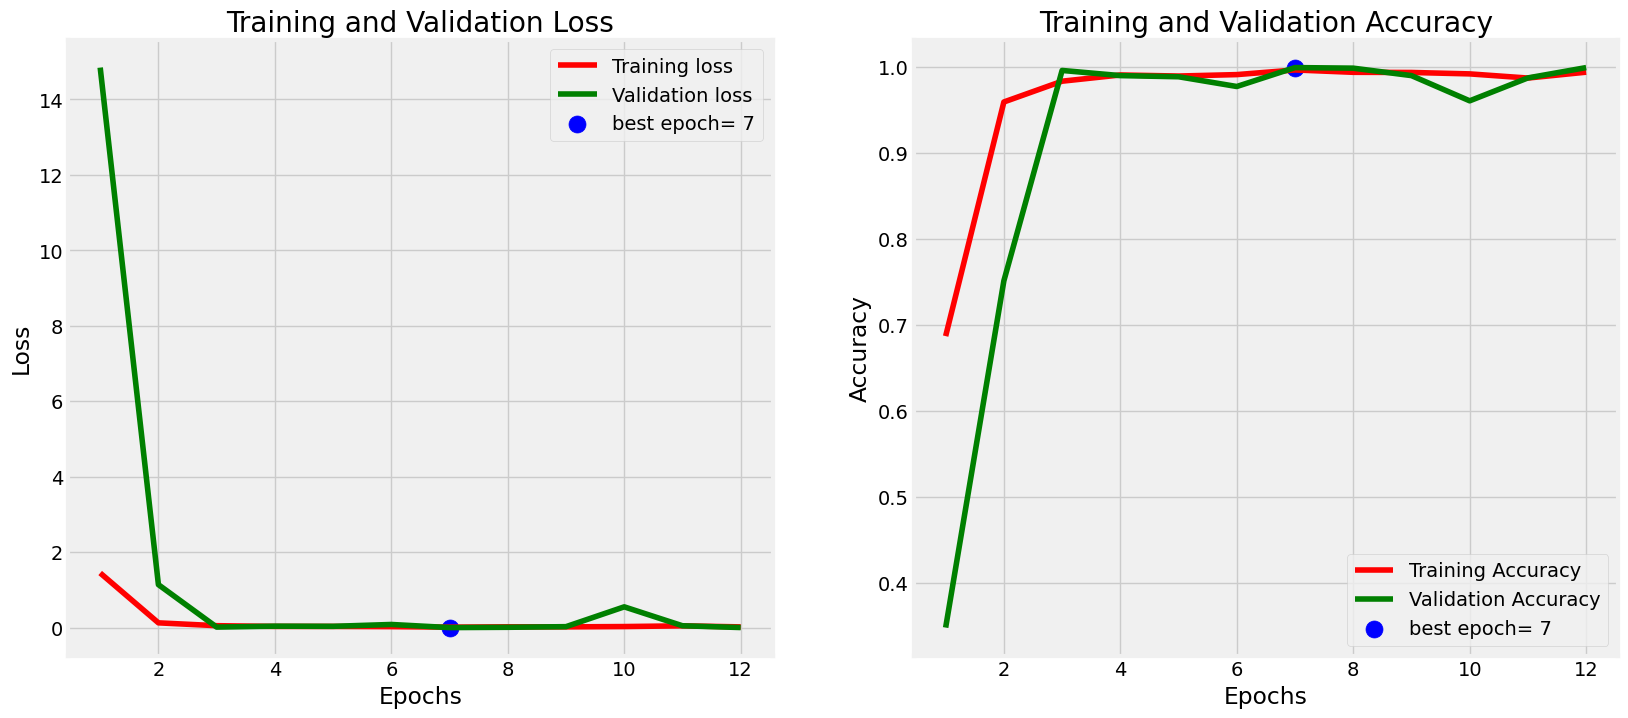

In [14]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()


## Evalution

In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.9987 - loss: 0.0028
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.9980 - loss: 0.0022
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 803ms/step - accuracy: 1.0000 - loss: 3.8136e-04
Train Loss:  0.0016898645553737879
Train Accuracy:  0.999218761920929
--------------------
Valid Loss:  0.0010557952336966991
Valid Accuracy:  0.999218761920929
--------------------
Test Loss:  0.0005578706040978432
Test Accuracy:  1.0


## predict

In [16]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 521ms/step


## Confusion Matrix

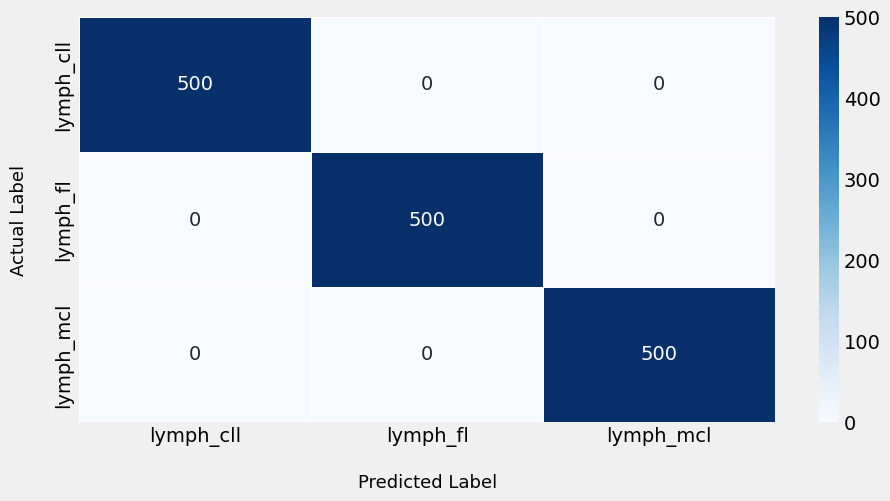

In [17]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

## Classification Report

In [18]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

   lymph_cll       1.00      1.00      1.00       500
    lymph_fl       1.00      1.00      1.00       500
   lymph_mcl       1.00      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



## Save Model

In [19]:
joblib.dump(model,"Lymphoma classification.pkl")

['Lymphoma classification.pkl']